*Read section 8.2.3 of the book before using these notes.*

*Note that in this course, lecture notes are not sufficient, you must read the book for better understanding. Lecture notes are just implementing the concepts of the book on a dataset, but not explaining the concepts elaborately.*

## Hyperparameters

There are 3 important parameters to tune in AdaBoost:

1. Number of trees 

2. Depth of each tree 

3. Learning rate  

Let us visualize the accuracy of AdaBoost when we independently tweak each of the above parameters.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split, KFold, cross_val_predict
from sklearn.metrics import mean_squared_error,r2_score,roc_curve,auc,precision_recall_curve, accuracy_score, \
recall_score, precision_score, confusion_matrix
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, StratifiedKFold
from sklearn.ensemble import BaggingRegressor,BaggingClassifier,AdaBoostRegressor,AdaBoostClassifier, \
RandomForestRegressor
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
import itertools as it
import time as time

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_objective, plot_histogram, plot_convergence
import warnings
from IPython import display

In [2]:
#Using the same datasets as used for linear regression in STAT303-2, 
#so that we can compare the non-linear models with linear regression
trainf = pd.read_csv('./Datasets/Car_features_train.csv')
trainp = pd.read_csv('./Datasets/Car_prices_train.csv')
testf = pd.read_csv('./Datasets/Car_features_test.csv')
testp = pd.read_csv('./Datasets/Car_prices_test.csv')
train = pd.merge(trainf,trainp)
test = pd.merge(testf,testp)
train.head()

,carID,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price
0,18473,bmw,6 Series,2020,Semi-Auto,11,Diesel,145,53.3282,3.0,37980
1,15064,bmw,6 Series,2019,Semi-Auto,10813,Diesel,145,53.0430,3.0,33980
2,18268,bmw,6 Series,2020,Semi-Auto,6,Diesel,145,53.4379,3.0,36850
3,18480,bmw,6 Series,2017,Semi-Auto,18895,Diesel,145,51.5140,3.0,25998
4,18492,bmw,6 Series,2015,Automatic,62953,Diesel,160,51.4903,3.0,18990


In [3]:
X = train[['mileage','mpg','year','engineSize']]
Xtest = test[['mileage','mpg','year','engineSize']]
y = train['price']
ytest = test['price']

## AdaBoost for regression

### Number of trees vs cross validation error
As the number of trees increases, the prediction bias will decrease, and the prediction variance will increase. Thus, there will be an optimal number of trees that minimizes the prediction error.

>2 9190.253 (757.408)
>5 8583.629 (341.406)
>10 8814.328 (248.891)
>50 10763.138 (465.677)
>100 11217.783 (602.642)
>500 11336.088 (763.288)
>1000 11390.043 (752.446)


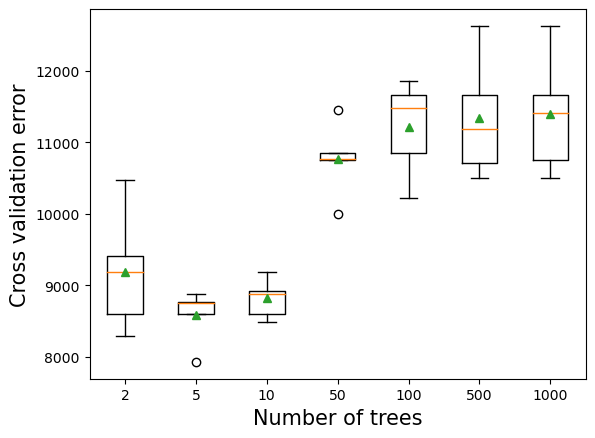

In [4]:
def get_models():
    models = dict()
    # define number of trees to consider
    n_trees = [2, 5, 10, 50, 100, 500, 1000]
    for n in n_trees:
        models[str(n)] = AdaBoostRegressor(n_estimators=n,random_state=1)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = KFold(n_splits=5, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = -cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X, y)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Number of trees',fontsize=15);

### Depth of tree vs cross validation error
As the depth of each weak learner (decision tree) increases, the complexity of the weak learner will increase. As the complexity increases, the prediction bias will decrease, while the prediction variance will increase. Thus, there will be an optimal depth for each weak learner that minimizes the prediction error.

>1 12798.764 (490.538)
>2 11031.451 (465.520)
>3 10739.302 (636.517)
>4 9491.714 (466.764)
>5 7184.489 (324.484)
>6 6181.533 (411.394)
>7 5746.902 (407.451)
>8 5587.726 (473.619)
>9 5526.291 (541.512)
>10 5444.928 (554.170)
>11 5321.725 (455.899)
>12 5279.581 (492.785)
>13 5494.982 (393.469)
>14 5423.982 (488.564)
>15 5369.485 (441.799)
>16 5536.739 (409.166)
>17 5511.002 (517.384)
>18 5510.922 (478.285)
>19 5482.119 (465.565)
>20 5667.969 (468.964)


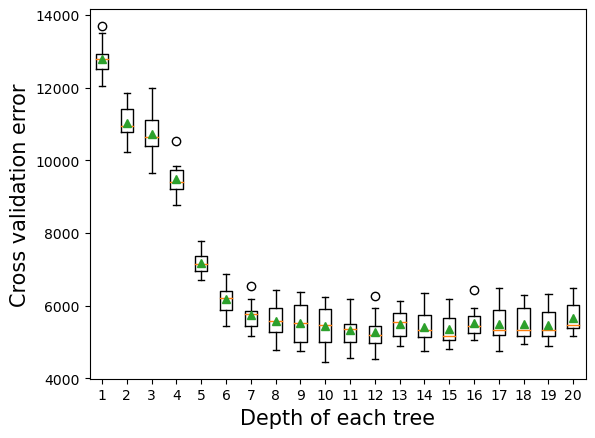

In [7]:
# get a list of models to evaluate
def get_models():
    models = dict()
    # explore depths from 1 to 10
    for i in range(1,21):
        # define base model
        base = DecisionTreeRegressor(max_depth=i)
        # define ensemble model
        models[str(i)] = AdaBoostRegressor(base_estimator=base,n_estimators=50)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = -cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X, y)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Depth of each tree',fontsize=15);

### Learning rate vs cross validation error
The optimal learning rate will depend on the number of trees, and vice-versa. If the learning rate is too low, it will take several trees to "learn" the response. If the learning rate is high, the response will be "learned" quickly (with fewer) trees.  Learning too quickly will be prone to overfitting, while learning too slowly will be computationally expensive. Thus, there will be an optimal learning rate to minimize the prediction error.

>0.1 8291.9 (452.4)
>0.2 8475.7 (465.3)
>0.3 8648.5 (458.8)
>0.4 8995.5 (438.6)
>0.5 9376.1 (388.2)
>0.6 9655.3 (551.8)
>0.7 9877.3 (319.8)
>0.8 10466.8 (528.3)
>0.9 10728.9 (386.8)
>1.0 10720.2 (410.6)
>1.1 11043.9 (432.5)
>1.2 10602.5 (570.0)
>1.3 11058.8 (362.1)
>1.4 11022.7 (616.0)
>1.5 11252.5 (839.3)
>1.6 11195.3 (604.5)
>1.7 11206.3 (636.1)
>1.8 11569.1 (674.6)
>1.9 11232.3 (605.6)
>2.0 11581.0 (824.8)


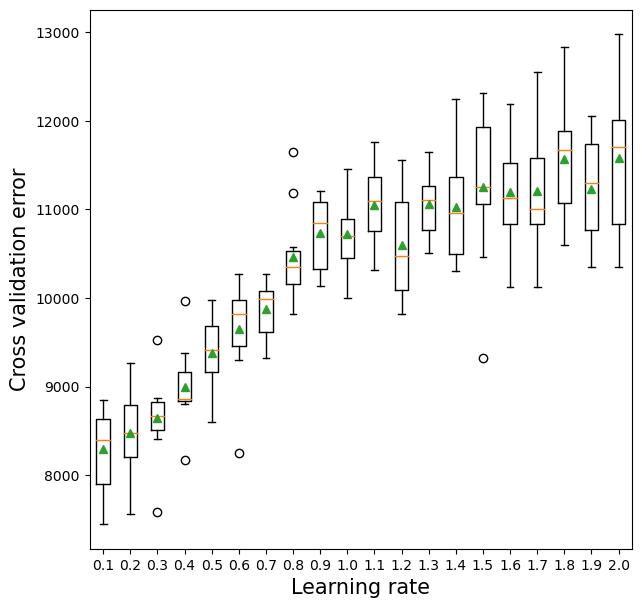

In [8]:
def get_models():
    models = dict()
    # explore learning rates from 0.1 to 2 in 0.1 increments
    for i in np.arange(0.1, 2.1, 0.1):
        key = '%.1f' % i
        models[key] = AdaBoostRegressor(learning_rate=i)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = -cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X, y)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.1f (%.1f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Learning rate',fontsize=15);

### Tuning AdaBoost for regression
As the optimal value of the parameters depend on each other, we need to optimize them simultaneously.

In [11]:
model = AdaBoostRegressor(random_state=1)
grid = dict()
grid['n_estimators'] = [10, 50, 100,200]
grid['learning_rate'] = [0.0001, 0.001, 0.01,0.1, 1.0]
grid['estimator'] = [DecisionTreeRegressor(max_depth=3), DecisionTreeRegressor(max_depth=5), 
                          DecisionTreeRegressor(max_depth=10),DecisionTreeRegressor(max_depth=15)]
# define the evaluation procedure
cv = KFold(n_splits=5, shuffle=True, random_state=1)
# define the grid search procedure
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='neg_root_mean_squared_error')
# execute the grid search
grid_result = grid_search.fit(X, y)
# summarize the best score and configuration
print("Best: %f using %s" % (-grid_result.best_score_, grid_result.best_params_))
# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

Best: 5346.490675 using {'estimator': DecisionTreeRegressor(max_depth=10), 'learning_rate': 1.0, 'n_estimators': 50}


Note that for tuning `max_depth` of the base estimator - decision tree, we specified 4 different base estimators with different depths. However, there is a more concise way to do that. We can specify the `max_depth` of the estimator by adding a double underscore "`__`" between the `estimator` and the hyperparameter that we wish to tune *(`max_depth` here)*, and then specify its potential values in the `grid` itself as shown below. However, we'll then need to add `DecisionTreeRegressor()` as the estimator within the `AdaBoostRegressor()` function.

In [12]:
model = AdaBoostRegressor(random_state=1, estimator = DecisionTreeRegressor(random_state=1))
grid = dict()
grid['n_estimators'] = [10, 50, 100,200]
grid['learning_rate'] = [0.0001, 0.001, 0.01,0.1, 1.0]
grid['estimator__max_depth'] = [3, 5, 10, 15]
# define the evaluation procedure
cv = KFold(n_splits=5, shuffle=True, random_state=1)
# define the grid search procedure
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='neg_root_mean_squared_error')
# execute the grid search
grid_result = grid_search.fit(X, y)
# summarize the best score and configuration
print("Best: %f using %s" % (-grid_result.best_score_, grid_result.best_params_))
# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

Best: 5346.490675 using {'estimator__max_depth': 10, 'learning_rate': 1.0, 'n_estimators': 50}


The BayesSearchCV() approach also coverges to a slightly different set of optimal hyperparameter values. However, it gives a similar cross-validated RMSE. This is possible. There may be multiple hyperparameter values that are different from each other, but similar in performance. It may be a good idea to ensemble models based on these two distinct set of hyperparameter values that give an equally accurate model.

['estimator__max_depth', 'learning_rate', 'n_estimators'] = [13, 1.0, 570] 5325.017602505734


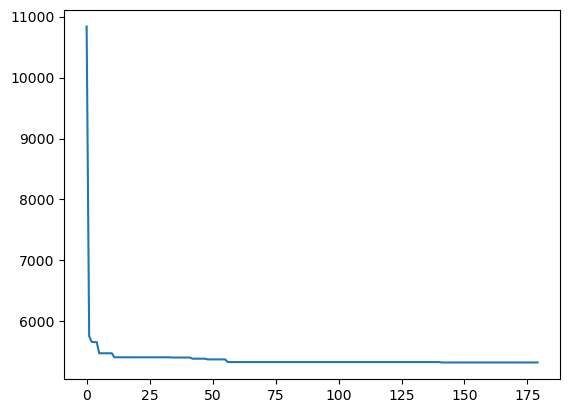

BayesSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
              estimator=AdaBoostRegressor(estimator=DecisionTreeRegressor()),
              n_iter=180, n_jobs=-1, random_state=10,
              scoring='neg_root_mean_squared_error',
              search_spaces={'estimator__max_depth': Integer(low=1, high=20, prior='uniform', transform='normalize'),
                             'learning_rate': Real(low=0.0001, high=1.0, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=2, high=1000, prior='uniform', transform='normalize')})

In [4]:
model = AdaBoostRegressor(estimator=DecisionTreeRegressor()) 
grid = dict()
grid['n_estimators'] = Integer(2, 1000)
grid['learning_rate'] = Real(0.0001, 1.0)
grid['estimator__max_depth'] = Integer(1, 20)

kfold = KFold(n_splits = 5, shuffle = True, random_state = 1)
gcv = BayesSearchCV(model, search_spaces = grid, cv = kfold, n_iter = 180, random_state = 10,
                         scoring = 'neg_root_mean_squared_error', n_jobs = -1)
paras = list(gcv.search_spaces.keys())
paras.sort()

def monitor(optim_result):
    cv_values = pd.Series(optim_result['func_vals']).cummin()
    display.clear_output(wait = True)
    min_ind = pd.Series(optim_result['func_vals']).argmin()
    print(paras, "=", optim_result['x_iters'][min_ind], pd.Series(optim_result['func_vals']).min())
    sns.lineplot(cv_values)
    plt.show()
gcv.fit(X, y, callback = monitor)

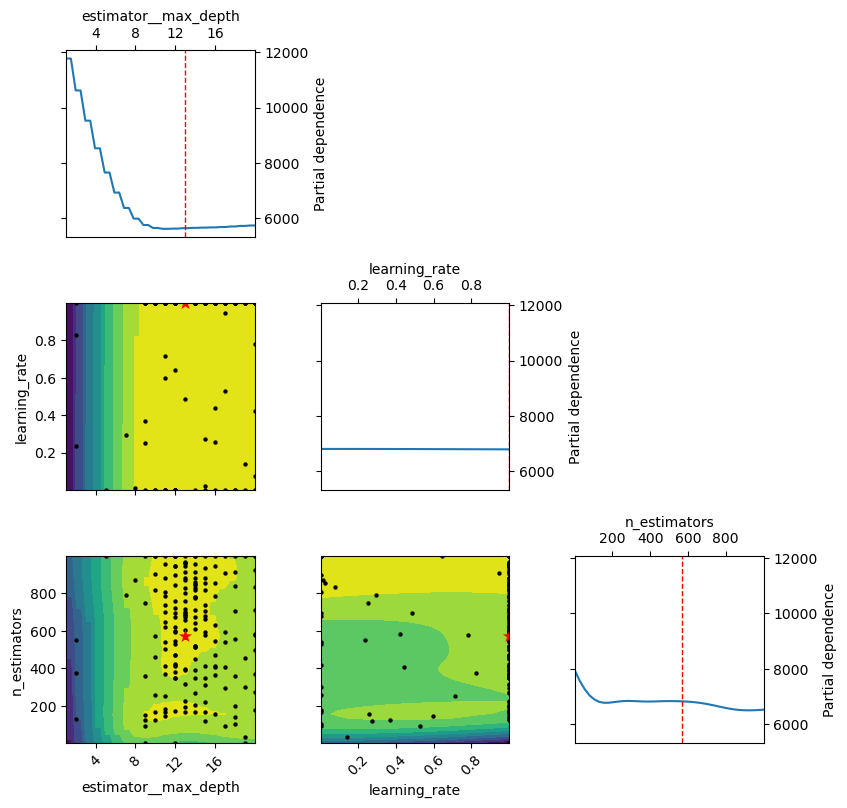

In [5]:
plot_objective(gcv.optimizer_results_[0],
                   dimensions=['estimator__max_depth', 'learning_rate', 'n_estimators'], size = 3)
plt.show();

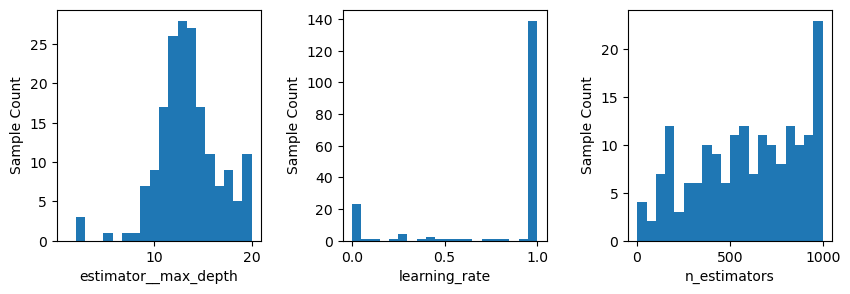

In [13]:
fig, ax = plt.subplots(1, 3, figsize = (10, 3))
plt.subplots_adjust(wspace=0.4)
plot_histogram(gcv.optimizer_results_[0], 0, ax = ax[0])
plot_histogram(gcv.optimizer_results_[0], 1, ax = ax[1])
plot_histogram(gcv.optimizer_results_[0], 2, ax = ax[2])
plt.show()

In [10]:
#Model based on the optimal hyperparameters
model = AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=10),n_estimators=50,learning_rate=1.0,
                         random_state=1).fit(X,y)

In [11]:
#RMSE of the optimized model on test data
pred1=model.predict(Xtest)
print("AdaBoost model RMSE = ", np.sqrt(mean_squared_error(model.predict(Xtest),ytest)))

AdaBoost model RMSE =  5693.165811600585


In [6]:
#Model based on the optimal hyperparameters
model = AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=13),n_estimators=570,learning_rate=1.0,
                         random_state=1).fit(X,y)

In [7]:
#RMSE of the optimized model on test data
pred2=model.predict(Xtest)
print("AdaBoost model RMSE = ", np.sqrt(mean_squared_error(model.predict(Xtest),ytest)))

AdaBoost model RMSE =  5434.852990644646


In [8]:
model = RandomForestRegressor(n_estimators=300, random_state=1,
                        n_jobs=-1, max_features=2).fit(X, y)
pred3 = model.predict(Xtest)
print("Random Forest model RMSE = ", np.sqrt(mean_squared_error(model.predict(Xtest),ytest)))

Random Forest model RMSE =  5642.45839697972


In [12]:
#Ensemble modeling
pred = 0.33*pred1+0.33*pred2 + 0.34*pred3
print("Ensemble model RMSE = ", np.sqrt(mean_squared_error(pred,ytest)))

Ensemble model RMSE =  5402.832128650372


Combined, the random forest model and the Adaboost models do better than each of the individual models.

## AdaBoost for classification
Below is the AdaBoost implementation on a classification problem. The takeaways are the same as that of the regression problem above.

In [16]:
train = pd.read_csv('./Datasets/diabetes_train.csv')
test = pd.read_csv('./Datasets/diabetes_test.csv')

In [17]:
X = train.drop(columns = 'Outcome')
Xtest = test.drop(columns = 'Outcome')
y = train['Outcome']
ytest = test['Outcome']

### Number of trees vs cross validation accuracy

>10 0.718 (0.060)
>50 0.751 (0.051)
>100 0.748 (0.053)
>500 0.690 (0.045)
>1000 0.694 (0.048)
>5000 0.691 (0.044)


Text(0.5, 0, 'Number of trees')

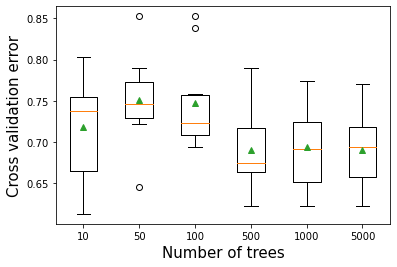

In [29]:
def get_models():
    models = dict()
    # define number of trees to consider
    n_trees = [10, 50, 100, 500, 1000, 5000]
    for n in n_trees:
        models[str(n)] = AdaBoostClassifier(n_estimators=n,random_state=1)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X, y)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Number of trees',fontsize=15)

### Depth of each tree vs cross validation accuracy

>1 0.751 (0.051)
>2 0.699 (0.063)
>3 0.696 (0.062)
>4 0.707 (0.055)
>5 0.713 (0.021)
>6 0.710 (0.061)
>7 0.733 (0.057)
>8 0.738 (0.044)
>9 0.727 (0.053)
>10 0.738 (0.065)
>11 0.748 (0.048)
>12 0.699 (0.044)
>13 0.738 (0.047)
>14 0.697 (0.041)
>15 0.697 (0.052)
>16 0.692 (0.052)
>17 0.702 (0.056)
>18 0.702 (0.045)
>19 0.700 (0.040)
>20 0.696 (0.042)


Text(0.5, 0, 'Depth of each tree')

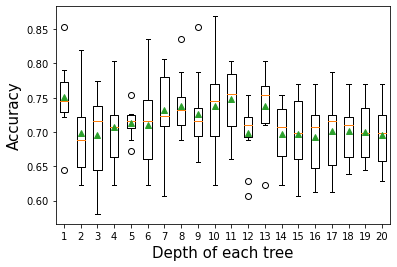

In [31]:
# get a list of models to evaluate
def get_models():
    models = dict()
    # explore depths from 1 to 10
    for i in range(1,21):
        # define base model
        base = DecisionTreeClassifier(max_depth=i)
        # define ensemble model
        models[str(i)] = AdaBoostClassifier(estimator=base)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X, y)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Accuracy',fontsize=15)
plt.xlabel('Depth of each tree',fontsize=15)

### Learning rate vs cross validation accuracy

>0.1 0.749 (0.052)
>0.2 0.743 (0.050)
>0.3 0.731 (0.057)
>0.4 0.736 (0.053)
>0.5 0.733 (0.062)
>0.6 0.738 (0.058)
>0.7 0.741 (0.056)
>0.8 0.741 (0.049)
>0.9 0.736 (0.048)
>1.0 0.741 (0.035)
>1.1 0.734 (0.037)
>1.2 0.736 (0.038)
>1.3 0.731 (0.057)
>1.4 0.728 (0.041)
>1.5 0.730 (0.036)
>1.6 0.720 (0.038)
>1.7 0.707 (0.045)
>1.8 0.730 (0.024)
>1.9 0.712 (0.033)
>2.0 0.454 (0.191)


Text(0.5, 0, 'Learning rate')

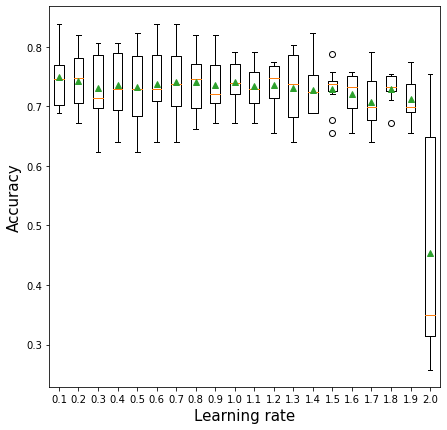

In [34]:
def get_models():
    models = dict()
    # explore learning rates from 0.1 to 2 in 0.1 increments
    for i in np.arange(0.1, 2.1, 0.1):
        key = '%.1f' % i
        models[key] = AdaBoostClassifier(learning_rate=i)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X, y)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Accuracy',fontsize=15)
plt.xlabel('Learning rate',fontsize=15)

### Tuning AdaBoost Classifier hyperparameters

In [19]:
model = AdaBoostClassifier(random_state=1, estimator = DecisionTreeClassifier())
grid = dict()
grid['n_estimators'] = [10, 50, 100,200,500]
grid['learning_rate'] = [0.0001, 0.001, 0.01,0.1, 1.0]
grid['estimator__max_depth'] = [1, 2, 3, 4]
# define the evaluation procedure
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
# define the grid search procedure
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, 
                          verbose = True)
# execute the grid search
grid_result = grid_search.fit(X, y)
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
#    print("%f (%f) with: %r" % (mean, stdev, param)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best: 0.763934 using {'estimator__max_depth': 3, 'learning_rate': 0.01, 'n_estimators': 200}


### Tuning the decision threshold probability
We’ll find a decision threshold probability that balances recall with precision.

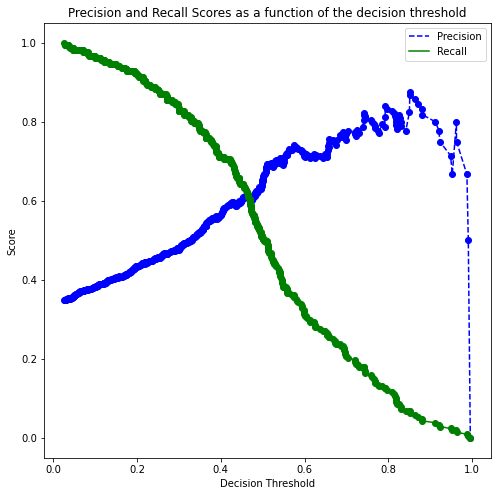

In [57]:
#Model based on the optimal parameters
model = AdaBoostClassifier(random_state=1, estimator = DecisionTreeClassifier(max_depth=3),learning_rate=0.01,
                          n_estimators=200).fit(X,y)

# Note that we are using the cross-validated predicted probabilities, instead of directly using the 
# predicted probabilities on train data, as the model may be overfitting on the train data, and 
# may lead to misleading results
cross_val_ypred = cross_val_predict(AdaBoostClassifier(random_state=1,base_estimator = DecisionTreeClassifier(max_depth=3),learning_rate=0.01,
                          n_estimators=200), X, y, cv = 5, method = 'predict_proba')

p, r, thresholds = precision_recall_curve(y, cross_val_ypred[:,1])
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.plot(thresholds, precisions[:-1], "o", color = 'blue')
    plt.plot(thresholds, recalls[:-1], "o", color = 'green')
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_precision_recall_vs_threshold(p, r, thresholds)

In [58]:
# Thresholds with precision and recall
all_thresholds = np.concatenate([thresholds.reshape(-1,1), p[:-1].reshape(-1,1), r[:-1].reshape(-1,1)], axis = 1)
recall_more_than_80 = all_thresholds[all_thresholds[:,2]>0.8,:]
# As the values in 'recall_more_than_80' are arranged in decreasing order of recall and increasing threshold,
# the last value will provide the maximum threshold probability for the recall to be more than 80%
# We wish to find the maximum threshold probability to obtain the maximum possible precision
recall_more_than_80[recall_more_than_80.shape[0]-1]

array([0.33488762, 0.50920245, 0.80193237])

In [59]:
#Optimal decision threshold probability
thres = recall_more_than_80[recall_more_than_80.shape[0]-1][0]
thres

0.3348876199649718

Accuracy:  79.87012987012987
ROC-AUC:  0.8884188260179798
Precision:  0.6875
Recall:  0.9016393442622951


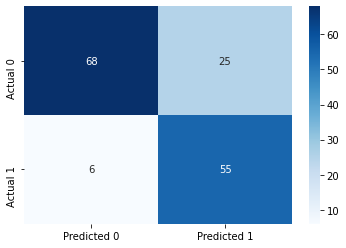

In [60]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = thres

y_pred_prob = model.predict_proba(Xtest)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, ytest)*100)  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(ytest, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(ytest, y_pred))
print("Recall: ", recall_score(ytest, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(ytest, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

The above model is similar to the one obtained with bagging / random forest. However, adaptive boosting may lead to better classification performance as compared to bagging / random forest.